In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeRegressor, export_text, export_graphviz
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

import xgboost as xgb


%matplotlib inline

In [2]:
columns = [
    'neighbourhood_group', 'room_type', 'latitude', 'longitude',
    'minimum_nights', 'number_of_reviews','reviews_per_month',
    'calculated_host_listings_count', 'availability_365',
    'price'
]

df = pd.read_csv('AB_NYC_2019.csv', usecols=columns)
df.reviews_per_month = df.reviews_per_month.fillna(0)
df.price = np.log1p(df.price)

In [3]:
pd.set_option("display.max_columns", None)
df.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
0,Brooklyn,40.64749,-73.97237,Private room,5.010635,1,9,0.21,6,365
1,Manhattan,40.75362,-73.98377,Entire home/apt,5.420535,1,45,0.38,2,355
2,Manhattan,40.80902,-73.94190,Private room,5.017280,3,0,0.00,1,365
3,Brooklyn,40.68514,-73.95976,Entire home/apt,4.499810,1,270,4.64,1,194
4,Manhattan,40.79851,-73.94399,Entire home/apt,4.394449,10,9,0.10,1,0


In [4]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [5]:
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.price.values
y_val = df_val.price.values
y_test = df_test.price.values

del df_train['price']
del df_val['price']
del df_test['price']


In [6]:
dv = DictVectorizer(sparse=False)

train_dict = df_train.to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

val_dict = df_val.to_dict(orient='records')
X_val = dv.fit_transform(val_dict)


Question 1

Let's train a decision tree regressor to predict the price variable.

Train a model with max_depth=1
Which feature is used for splitting the data?

room_type
neighbourhood_group
number_of_reviews
reviews_per_month

In [7]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=1)

In [8]:
print(export_text(dt, feature_names=dv.get_feature_names()))

|--- room_type=Entire home/apt <= 0.50
|   |--- value: [4.29]
|--- room_type=Entire home/apt >  0.50
|   |--- value: [5.15]



Question 2

Train a random forest model with these parameters:

n_estimators=10
random_state=1
n_jobs=-1 (optional - to make training faster)

What's the RMSE of this model on validation?

In [9]:
rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

prediction = rf.predict(X_val)
rmse = mean_squared_error(y_val, prediction, squared=False)
print('RMSE of the model on validation is: ', round(rmse, 3))

RMSE of the model on validation is:  0.462


Question 3

Now let's experiment with the n_estimators parameter

Try different values of this parameter from 10 to 200 with step 10
Set random_state to 1
Evaluate the model on the validation dataset
After which value of n_estimators does RMSE stop improving?

10
50
70
120

In [18]:
n_estimators = np.arange(10, 210, 10)

for n in n_estimators:
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train, y_train)

    prediction = rf.predict(X_val)
    rmse = round(mean_squared_error(y_val, prediction, squared=False), 3)
    # print('RMSE of the model on validation is: ', round(rmse, 3))
    print(f'When n is {n}, the RMSE of the model is: {rmse}')

When n is 10, the RMSE of the model is: 0.462
When n is 20, the RMSE of the model is: 0.448
When n is 30, the RMSE of the model is: 0.446
When n is 40, the RMSE of the model is: 0.444
When n is 50, the RMSE of the model is: 0.442
When n is 60, the RMSE of the model is: 0.442
When n is 70, the RMSE of the model is: 0.441
When n is 80, the RMSE of the model is: 0.441
When n is 90, the RMSE of the model is: 0.441
When n is 100, the RMSE of the model is: 0.44
When n is 110, the RMSE of the model is: 0.439
When n is 120, the RMSE of the model is: 0.439
When n is 130, the RMSE of the model is: 0.439
When n is 140, the RMSE of the model is: 0.439
When n is 150, the RMSE of the model is: 0.439
When n is 160, the RMSE of the model is: 0.439
When n is 170, the RMSE of the model is: 0.439
When n is 180, the RMSE of the model is: 0.439
When n is 190, the RMSE of the model is: 0.439
When n is 200, the RMSE of the model is: 0.439


Question 4

Let's select the best max_depth:

Try different values of max_depth: [10, 15, 20, 25]
For each of these values, try different values of n_estimators from 10 till 200 (with step 10)
Fix the random seed: random_state=1
What's the best max_depth:

10
15
20
25

In [23]:
max_depth = [10, 15, 20, 25]
n_estimators = np.arange(10, 210, 10)

for depth in max_depth:
    print(f'Depth is: {depth}')
    
    for n in n_estimators:
        rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
        rf.fit(X_train, y_train)

        prediction = rf.predict(X_val)
        rmse = round(mean_squared_error(y_val, prediction, squared=False), 3)
        print(f'When n is {n}, the RMSE of the model is: {rmse}')

Depth is: 10
When n is 10, the RMSE of the model is: 0.462
When n is 20, the RMSE of the model is: 0.448
When n is 30, the RMSE of the model is: 0.446
When n is 40, the RMSE of the model is: 0.444
When n is 50, the RMSE of the model is: 0.442
When n is 60, the RMSE of the model is: 0.442
When n is 70, the RMSE of the model is: 0.441
When n is 80, the RMSE of the model is: 0.441
When n is 90, the RMSE of the model is: 0.441
When n is 100, the RMSE of the model is: 0.44
When n is 110, the RMSE of the model is: 0.439
When n is 120, the RMSE of the model is: 0.439
When n is 130, the RMSE of the model is: 0.439
When n is 140, the RMSE of the model is: 0.439
When n is 150, the RMSE of the model is: 0.439
When n is 160, the RMSE of the model is: 0.439
When n is 170, the RMSE of the model is: 0.439
When n is 180, the RMSE of the model is: 0.439
When n is 190, the RMSE of the model is: 0.439
When n is 200, the RMSE of the model is: 0.439
Depth is: 15
When n is 10, the RMSE of the model is: 0.46

Question 5

We can extract feature importance information from tree-based models.

At each step of the decision tree learning algorith, it finds the best split. When doint it, we can calculate "gain" - the reduction in impurity before and after the split. This gain is quite useful in understanding what are the imporatant features for tree-based models.

In Scikit-Learn, tree-based models contain this information in the feature_importances_ field.

For this homework question, we'll find the most important feature:

Train the model with these parametes:
n_estimators=10,
max_depth=20,
random_state=1,
n_jobs=-1 (optional)
Get the feature importance information from this model
What's the most important feature?

neighbourhood_group=Manhattan
room_type=Entire home/apt
longitude
latitude

In [53]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
features = dv.get_feature_names()

for f, i in zip(features, importances):
    forest_importances = pd.Series(importances, index=features).sort_values()
    print(forest_importances)
    print('\nThe most important feature is ', features[np.argmax(importances)])

neighbourhood_group=Staten Island    0.000084
neighbourhood_group=Bronx            0.000265
neighbourhood_group=Brooklyn         0.000966
neighbourhood_group=Queens           0.001166
room_type=Private room               0.004032
room_type=Shared room                0.005023
calculated_host_listings_count       0.030102
neighbourhood_group=Manhattan        0.034047
number_of_reviews                    0.041594
minimum_nights                       0.053252
reviews_per_month                    0.054430
availability_365                     0.076264
latitude                             0.152775
longitude                            0.154101
room_type=Entire home/apt            0.391898
dtype: float64

The most important feature is  room_type=Entire home/apt
neighbourhood_group=Staten Island    0.000084
neighbourhood_group=Bronx            0.000265
neighbourhood_group=Brooklyn         0.000966
neighbourhood_group=Queens           0.001166
room_type=Private room               0.004032
room_ty

Now let's train an XGBoost model! For this question, we'll tune the eta parameter

Install XGBoost
Create DMatrix for train and validation
Create a watchlist
Train a model with these parameters for 100 rounds:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}
Now change eta first to 0.1 and then to 0.01

What's the best eta?

0.3
0.1
0.01


In [16]:
features = dv.get_feature_names()
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [22]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_rmse', 'val_rmse']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

First, try eta = 0.3

In [23]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'reg:squarederror',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

scores = {}

In [24]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [25]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Now we try eta = 0.1

In [26]:
xgb_params["eta"] = 0.1

In [27]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [28]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

Finally we try eta = 0.01

In [29]:
xgb_params["eta"] = 0.01

In [30]:
%%capture output
model = xgb.train(xgb_params, dtrain, num_boost_round=100, verbose_eval=5, evals=watchlist)

In [31]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)

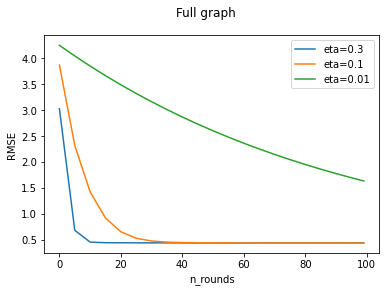

In [46]:
fig = plt.figure()

for eta, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)

    plt.xlabel('n_rounds')
    plt.ylabel('RMSE')
    plt.legend()
    fig.suptitle('Full graph')


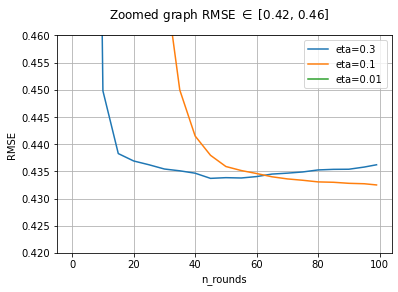

In [56]:
fig = plt.figure()

for eta, df_score in scores.items():
    high, low = 0.46, 0.42
    # left, right = 40, 80
    plt.plot(df_score.num_iter, df_score.val_rmse, label=eta)
    plt.xlabel('n_rounds')
    plt.ylabel('RMSE')
    plt.ylim(low, high)
    # plt.xlim(left, right)
    plt.grid()
    plt.legend()
    fig.suptitle(f'Zoomed graph RMSE $\in$ [{low}, {high}]')
